# Initialization

In [18]:
from copy import deepcopy

In [1]:
import numpy as np
from pprint import pprint


from laboneq.contrib.example_helpers.generate_descriptor import generate_descriptor
#from laboneq.contrib.example_helpers.generate_device_setup import generate_device_setup
from laboneq.dsl.device import DeviceSetup




descriptor = generate_descriptor(
    #pqsc=[""], # 장비 여러개 사용시
    shfqc_6=["DEV12256"],
    number_data_qubits=3,
    multiplex=True,
    number_multiplex=3,
    include_cr_lines=True,
    include_ef_lines=True,
    get_zsync=False,  # Only set to True when using real device
    save = True,
    filename="TG_KAIST",
    ip_address="192.168.0.83"
)


#descriptor
setup = DeviceSetup.from_descriptor(yaml_text=descriptor, server_host="192.168.0.83")
#setup
setup.instruments[0].device_options = 'SHFQC/PLUS/QC6CH'
#setup.instruments

In [20]:
from laboneq.simple import Session
session = Session(setup)
session.connect(ignore_version_mismatch=True, do_emulation=False)
#session.disconnect()

[2025.10.29 10:02:38.886] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is /home/yalgaeahn/JSAHN/qubit-experiment/examples/laboneq_output/log
[2025.10.29 10:02:38.888] INFO    VERSION: laboneq 2.61.0
[2025.10.29 10:02:38.888] INFO    Connecting to data server at 192.168.0.83:8004
[2025.10.29 10:02:38.981] INFO    Connected to Zurich Instruments LabOne Data Server version 25.07.0.507 at 192.168.0.83:8004
[2025.10.29 10:02:39.013] INFO    Configuring the device setup
[2025.10.29 10:02:39.034] INFO    The device setup is configured


In [21]:
from qpu_types import TransmonQubit, TransmonQubitParameters
from helper import load_qubit_parameters, save_qubit_parameters
from operations import TransmonOperations
from laboneq.dsl.quantum.qpu import QPU, QuantumPlatform



_loaded_qubits = load_qubit_parameters(filename="20251023-1101_TG_1022") 
#qubits = TransmonQubit.from_device_setup(setup) # Also can be done with load_qubit_parameters 
qubits = list(_loaded_qubits.values())





qpu = QPU(quantum_elements=qubits, quantum_operations=TransmonOperations())
#quantum_platform = QuantumPlatform(setup=setup, qpu=qpu)

# qpu.topology.add_edge("bus", "q16", "q17")
# qpu.topology.add_edge("bus", "q17", "q18")
# qpu.topology.add_edge("bus", "q18", "q19")
# qpu.topology.plot()




from laboneq.simple import workflow
folder_store = workflow.logbook.FolderStore("./experiment_store") 
folder_store.activate()
#folder_store.deactivate()
#workflow.logbook.LoggingStore().activate()
#workflow.logbook.LogbookStore().deactivate()


In [22]:
folder_store.activate()

BF 7

In [23]:
# 0 : 15 , 1 : 16 , 2 : 17, 3 : 18, 4 : 19
for q in qubits:
    #q.parameters.ge_drive_pulse["sigma"] = 0.25
    q.parameters.readout_amplitude = 1.0
    q.parameters.reset_delay_length = 20e-6

    q.parameters.readout_range_out = -10
    q.parameters.readout_range_in = 0
    q.parameters.drive_range = 10

    q.parameters.readout_lo_frequency = 7.6e9
    q.parameters.drive_lo_frequency = 4.8e9

    q.parameters.spectroscopy_length = 10e-6

    q.parameters.ge_drive_length =64e-9
    q.parameters.readout_integration_delay =  200e-9#####

 
qubits[0].parameters.resonance_frequency_ge = 4.9613e9
qubits[0].parameters.readout_resonator_frequency = 7.6283e9

qubits[1].parameters.resonance_frequency_ge = 4.7065e9
qubits[1].parameters.readout_resonator_frequency = 7.3116e9

qubits[2].parameters.drive_lo_frequency = 5.6e9
qubits[2].parameters.resonance_targ_frequency = 5.6e9
# qubits[2].parameters.resonance_frequency_ge = 4.716e9
# qubits[3].parameters.resonance_frequency_ge = 4.664e9
# qubits[4].parameters.resonance_frequency_ge = 4.779e9

# qubits[2].parameters.readout_resonator_frequency = 6.9226e9
# qubits[3].parameters.readout_resonator_frequency = 6.8433e9
# qubits[4].parameters.readout_resonator_frequency = 6.7739e9



3 oscillator to be calibrated
- `drive_local_osc`
- `readout_local_osc`
- `readout_acquire_osc`

In [24]:
# from laboneq.dsl.calibration import Calibration, Oscillator, SignalCalibration

# sibal= SignalCalibration()
# sibal.delay_signal

In [25]:
# from experiments import signal_propagation_delay
# options = signal_propagation_delay.experiment_workflow.options()
#workflow.show_fields(options)

Correcting propagation delay. 

$\Delta \phi =-2\pi f t$ $\implies$ $\tau = \frac{1}{\Delta f}$

In [26]:
# from experiments import signal_propagation_delay
# ####################################################################################
# qubits[0].parameters.readout_amplitude =1.0
# q=qubits[0]
# delays=np.linspace(0e-9, 200e9, 51)
# measure_delays = 40e-6
# pprint(q.readout_parameters())
# print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
# #####################################################################################
# options = signal_propagation_delay.experiment_workflow.options()
# #workflow.show_fields(options)
# options.update(False)
# ######################################################################################
# # Build and run resonator_spectroscopy_amplitude wormflow
# prop_delay = signal_propagation_delay.experiment_workflow(
#     session=session,
#     qpu=qpu,
#     qubit=q,
#     delays=delays,
#     measure_delay=measure_delays,
#     options=options
# )
# prop_delay_result=prop_delay.run()
# prop_delay_analysis_result = prop_delay_result.tasks["analysis_workflow"]
# pprint(prop_delay_analysis_result.output)

In [27]:
prop_delay_analysis_result.tasks["plot_data"].output['q0']

NameError: name 'prop_delay_analysis_result' is not defined

# 1. Spectroscopy

In [ ]:

qubits[0].parameters.drive_range = 10
qubits[0].parameters.readout_range_out= -10

In [ ]:
from helper import adjust_amplitude_for_output_range, calculate_power
adjust_amplitude_for_output_range(initial_output_dbm=0, initial_amplitude= 0.002, new_output_dbm=-5)
calculate_power(output_dbm=0, amplitude=0.001,attenuation=[])

### 1.1 Resonator spectroscopy with amplitude sweep

STRATEGY
1. CW spectroscpy for wide range scan
    * CW spectroscopy can be done for wide range scan 
    * amplitude, frequency 2D sweep 을 통해  power에 따른 broadening 및 SNR 경향 관찰
    * $\Delta F$ : frequency span,  $\Delta f_r$
    * Pick $\Delta F / \Delta f_r$ 1~2

In [ ]:
qubits[1].parameters.drive_range = 10

In [2]:
from experiments import resonator_spectroscopy_amplitude

####################################################################################
qubits[0].parameters.readout_amplitude =0.8
q=qubits[0]
pprint(q.readout_parameters())
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
frequencies = q.parameters.readout_resonator_frequency + np.linspace(-5e6,5e6,101)
amplitudes = np.linspace(0.0, 1.0, 21) #This works as scaling factor!!!!!!!!!!!!
#####################################################################################
options = resonator_spectroscopy_amplitude.experiment_workflow.options()
#workflow.show_fields(options)
options.update(False)
options.use_cw(False)
options.do_analysis(True)
######################################################################################
# Build and run resonator_spectroscopy_amplitude wormflow
res_spec_amp = resonator_spectroscopy_amplitude.experiment_workflow(
    session=session,
    qpu=qpu,
    qubit=q,
    frequencies=frequencies,
    amplitudes=amplitudes,
    options=options
)
res_spec_amp_result=res_spec_amp.run()


NameError: name 'qubits' is not defined

In [ ]:
res_spec_amp_result.tasks["analysis_workflow"].tasks["plot_signal_magnitude_and_phase_2d"].output["q0"]

In [ ]:
# qubits[0].parameters

### 1.2 Resonator Spectroscopy
* CW not recommended 

In [41]:
from experiments import resonator_spectroscopy

####################################################################################
q=qubits[1]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temp_pars.readout_amplitude = 0.8
temporary_parameters[q.uid] = temp_pars
print(q.readout_parameters())
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
#frequencies = q.parameters.readout_resonator_frequency + np.linspace(-10e6,10e6,501)
frequencies = q.parameters.readout_resonator_frequency + np.linspace(-5e6,5e6,1001)
#####################################################################################
options = resonator_spectroscopy.experiment_workflow.options()
#workflow.show_fields(options)
options.count(1024)
options.update(True)
options.use_cw(False) #qop.measure 
options.fit_complex_resonator(False)
options.fit_lorentzian(True)
######################################################################################
# Build and run resonator_spectroscopy_amplitude wormflow
res_spec = resonator_spectroscopy.experiment_workflow(
    session=session,
    qpu=qpu,
    qubit=q,
    frequencies=frequencies,
    options=options,
    temporary_parameters=temporary_parameters
)
res_spec_result = res_spec.run()
res_spec_analysis_result = res_spec_result.tasks["analysis_workflow"]
pprint(res_spec_analysis_result.output)

('measure', {'amplitude': 1.0, 'length': 2e-06, 'pulse': {'function': 'GaussianSquare', 'sigma': 0.2, 'risefall_sigma_ratio': 3.0}})
DRIVE range (dBm) : 10, READOUT range (dBm) : -10
[2025.10.29 10:35:16.018] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.10.29 10:35:16.018] INFO      Workflow 'resonator_spectroscopy': execution started at 2025-10-29            
[2025.10.29 10:35:16.019] INFO      01:35:16.018222Z                                                              
[2025.10.29 10:35:16.019] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.10.29 10:35:16.027] INFO    Task 'temporary_qpu': started at 2025-10-29 01:35:16.026844Z
[2025.10.29 10:35:16.027] INFO    Task 'temporary_qpu': ended at 2025-10-29 01:35:16.027810Z
[2025.10.29 10:35:16.029] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2025-10-29 
[2025.10.29 10:35:16.029] INFO    01:35:16.029252Z
[2025.10.29 10:35

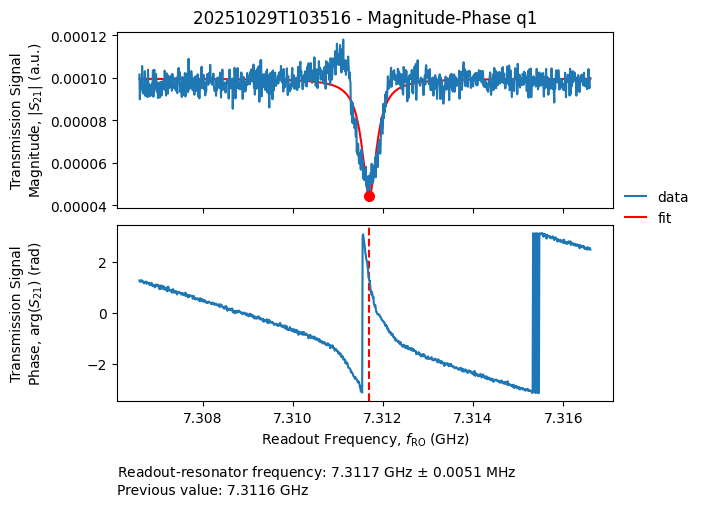

In [42]:
res_spec_analysis_result.tasks['plot_magnitude_phase'].output

In [30]:
# res_spec_result.tasks["analysis_workflow"].tasks["plot_real_imaginary"].output

In [31]:
from laboneq.simple import show_pulse_sheet
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

#show_pulse_sheet(compiled_experiment=res_spec_result.tasks["compile_experiment"].output,name='test', interactive=True)
#plot_simulation(compiled_experiment=res_spec_result.tasks["compile_experiment"].output)

### 2.1 Qubit Spectroscopy with Amplitude Sweep
* Current qubit spectroscopy modules do not support CW 
* Recommended to use long enough spectroscopy drive (pulsed) to see steady state signals

In [ ]:
from experiments import qubit_spectroscopy_amplitude

###############################################################
q = qubits[1]
frequencies = q.parameters.resonance_frequency_ge + np.linspace(-2e6, 2e6, 101)
amplitudes = np.linspace(0.01, 1.0, 11)
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")

pprint(q.readout_parameters())
pprint(q.spectroscopy_parameters())
################################################################
options = qubit_spectroscopy_amplitude.experiment_workflow.options()
options.update(False)
# workflow.show_fields(options)
###################################################################
qubit_spec_amp = qubit_spectroscopy_amplitude.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    frequencies=frequencies,
    amplitudes=amplitudes,
    options=options
)

qubit_spec_amp_result = qubit_spec_amp.run()
qubit_spec_amp_result

### 2.2 Qubit Spectroscopy 


In [43]:
from experiments import qubit_spectroscopy

###############################################################
q = qubits[1]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temp_pars.spectroscopy_amplitude = 0.002
temporary_parameters[q.uid] = temp_pars

#q.parameters.readout_amplitude = 1.0
frequencies = q.parameters.resonance_frequency_ge + np.linspace(-2e6, 2e6, 401)
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
pprint(q.readout_parameters())
pprint(q.spectroscopy_parameters())
################################################################
options = qubit_spectroscopy.experiment_workflow.options()
options.update(True)
options.count(1024)
# workflow.show_fields(options)
###################################################################
qubit_spec = qubit_spectroscopy.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    frequencies=frequencies,
    options=options,
    temporary_parameters=temporary_parameters
)

qubit_spec_result = qubit_spec.run()
qubit_spec_result

DRIVE range (dBm) : 10, READOUT range (dBm) : -10
('measure',
 {'amplitude': 1.0,
  'length': 2e-06,
  'pulse': {'function': 'GaussianSquare',
            'risefall_sigma_ratio': 3.0,
            'sigma': 0.2}})
('drive',
 {'amplitude': 0.002,
  'length': 1e-05,
  'pulse': {'function': 'GaussianSquare',
            'risefall_sigma_ratio': 3.0,
            'sigma': 0.2}})
[2025.10.29 10:35:58.255] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.10.29 10:35:58.255] INFO      Workflow 'qubit_spectroscopy': execution started at 2025-10-29                
[2025.10.29 10:35:58.255] INFO      01:35:58.255129Z                                                              
[2025.10.29 10:35:58.256] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.10.29 10:35:58.263] INFO    Task 'temporary_qpu': started at 2025-10-29 01:35:58.263289Z
[2025.10.29 10:35:58.264] INFO    Task 'temporary_qpu': ended at 2025-1

WorkflowResult(name=qubit_spectroscopy, index=())

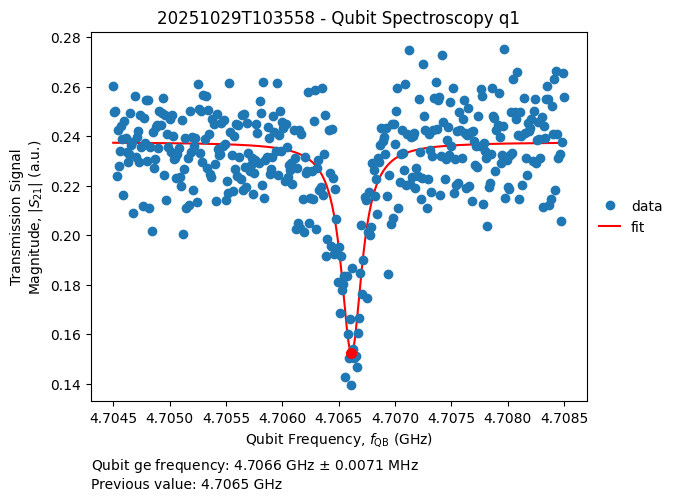

In [55]:
qubit_spec_result.tasks['analysis_workflow'].tasks['plot_qubit_spectroscopy'].output['q1']

# T1 

In [ ]:
from laboneq_applications.experiments import lifetime_measurement

In [33]:
from laboneq_applications.experiments import lifetime_measurement


###############################################################
q = qubits[0]

#q.parameters.readout_amplitude = 1.0

print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
pprint(q.readout_parameters())
pprint(q.spectroscopy_parameters())
################################################################
options = lifetime_measurement.experiment_workflow.options()
options.update(True)
options.count(1024)
# workflow.show_fields(options)
###################################################################
t1 = lifetime_measurement.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    options=options,
    delays = np.linspace(0e-6, 20e-6, 101)
)

t1_result = t1.run()
qubit_spec_result

DRIVE range (dBm) : 10, READOUT range (dBm) : -10
('measure',
 {'amplitude': 1.0,
  'length': 2e-06,
  'pulse': {'function': 'GaussianSquare',
            'risefall_sigma_ratio': 3.0,
            'sigma': 0.2}})
('drive',
 {'amplitude': 0.002,
  'length': 1e-05,
  'pulse': {'function': 'GaussianSquare',
            'risefall_sigma_ratio': 3.0,
            'sigma': 0.2}})
[2025.10.29 10:05:07.343] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.10.29 10:05:07.343] INFO      Workflow 'lifetime_measurement': execution started at 2025-10-29              
[2025.10.29 10:05:07.343] INFO      01:05:07.343112Z                                                              
[2025.10.29 10:05:07.344] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.10.29 10:05:07.352] INFO    Task 'temporary_qpu': started at 2025-10-29 01:05:07.352102Z
[2025.10.29 10:05:07.353] INFO    Task 'temporary_qpu': ended at 2025-1

WorkflowResult(name=qubit_spectroscopy, index=())

# 2. Rabi

## 2.1 Rabi Amplitude 

In [58]:
qubits[0].parameters.drive_range 

10

In [59]:
from laboneq_applications.experiments import amplitude_rabi
q = qubits[1]

#######################################################################
amplitudes = np.linspace(0.02, 1.0,101)
print(q.parameters.ge_drive_amplitude_pi)
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
#######################################################################
options = amplitude_rabi.experiment_workflow.options()
options.update(True)
options.use_cal_traces(True)
options.do_pca(False)
#print(workflow.show_fields(options))

###################################################################
rabi_amp = amplitude_rabi.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    amplitudes=amplitudes,
    options=options
)

rabi_amp_result = rabi_amp.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(rabi_amp_result.tasks['analysis_workflow'].output)

0.6469305724759834
DRIVE range (dBm) : 10, READOUT range (dBm) : -10
[2025.10.29 10:40:29.563] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.10.29 10:40:29.564] INFO      Workflow 'amplitude_rabi': execution started at 2025-10-29 01:40:29.563314Z   
[2025.10.29 10:40:29.564] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.10.29 10:40:29.574] INFO    Task 'temporary_qpu': started at 2025-10-29 01:40:29.574612Z
[2025.10.29 10:40:29.575] INFO    Task 'temporary_qpu': ended at 2025-10-29 01:40:29.575709Z
[2025.10.29 10:40:29.577] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2025-10-29 
[2025.10.29 10:40:29.578] INFO    01:40:29.577656Z
[2025.10.29 10:40:29.578] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2025-10-29 01:40:29.578387Z
[2025.10.29 10:40:29.579] INFO    Task 'create_experiment': started at 2025-10-29 01:40:29.579167Z
[2025.10.29 10:40:29.584] INFO  

## 2.2 (optional) Rabi Amplitude Chevron 

In [ ]:
from experiments import amplitude_rabi_chevron

#######################################################################
q = qubits[0]
amplitudes = np.linspace(0,1.0,11)
frequencies = q.parameters.resonance_frequency_ge + np.linspace(-3e6, 3e6, 51)
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
#######################################################################
options = amplitude_rabi_chevron.experiment_workflow.options()

#print(workflow.show_fields(options))

###################################################################
rabi_amp_chev = amplitude_rabi_chevron.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    frequencies=frequencies,
    amplitudes=amplitudes,
    options=options
)

rabi_amp_chev_result = rabi_amp_chev.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(rabi_amp_chev_result.tasks['analysis_workflow'].output)


## 2.3 (optional) Rabi Length
- Not working yet

In [ ]:
# from experiments import time_rabi
# #######################################################################
# q = qubits[2]
# q.parameters.ge_drive_amplitude_pi = 0.3
# lengths = np.linspace(0.0, 240e-9, 21 ),
# print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
# #######################################################################
# options = time_rabi.experiment_workflow.options()

# #print(workflow.show_fields(options))

# ###################################################################
# rabi_length = time_rabi.experiment_workflow(
#     session=session,
#     qpu=qpu,
#     qubits=q,
#     lengths=lengths,
#     options=options
# )

# rabi_length_result = rabi_length.run()
# #qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
# print(rabi_length_result.tasks['analysis_workflow'].output)


## 2.2 (optional) Rabi Length Chevron

In [ ]:
# from experiments import time_rabi_chevron
# #######################################################################
# q = qubits[4]

# frequencies = q.parameters.resonance_frequency_ge + np.linspace(-5e6, 5e6, 21)
# lengths = np.linspace(0.0, 240e-9, 21 ),
# print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
# #######################################################################
# options = time_rabi_chevron.experiment_workflow.options()

# #print(workflow.show_fields(options))

# ###################################################################
# rabi_length_chev = time_rabi_chevron.experiment_workflow(
#     session=session,
#     qpu=qpu,
#     qubits=q,
#     frequencies=frequencies,
#     lengths=lengths,
#     options=options
# )

# rabi_length_chev_result = rabi_length_chev.run()
# #qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
# print(rabi_length_chev_result.tasks['analysis_workflow'].output)


# 3. Ramsey

In [60]:
from experiments import ramsey

q = qubits[1]
#######################################################################
delays = np.linspace(0,6e-6,301)
detunings = 0.5e6
pprint(q.readout_parameters())
#######################################################################
options = ramsey.experiment_workflow.options()
options.update(True)
options.count(1024)
options.use_cal_traces(True)
# Build and run Ramsey workflow (no explicit command table options required)
ramsey_wf = ramsey.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    delays=delays,
    detunings=detunings,
    options=options
)
ramsey_result = ramsey_wf.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(ramsey_result.tasks['analysis_workflow'].output)

('measure',
 {'amplitude': 1.0,
  'length': 2e-06,
  'pulse': {'function': 'GaussianSquare',
            'risefall_sigma_ratio': 3.0,
            'sigma': 0.2}})
[2025.10.29 10:41:06.146] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.10.29 10:41:06.146] INFO      Workflow 'ramsey': execution started at 2025-10-29 01:41:06.146188Z           
[2025.10.29 10:41:06.147] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.10.29 10:41:06.153] INFO    Task 'temporary_qpu': started at 2025-10-29 01:41:06.153589Z
[2025.10.29 10:41:06.154] INFO    Task 'temporary_qpu': ended at 2025-10-29 01:41:06.154374Z
[2025.10.29 10:41:06.155] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2025-10-29 
[2025.10.29 10:41:06.156] INFO    01:41:06.155725Z
[2025.10.29 10:41:06.156] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2025-10-29 01:41:06.156391Z
[2025.10.29 10:41:06.157] INFO    Task

In [61]:
from laboneq_applications.experiments import amplitude_fine
q = qubits[1]
temporary_parameters = q.parameters.copy()

#######################################################################
repetitions =np.arange(1,10)
#######################################################################
options = amplitude_fine.experiment_workflow_x180.options()
options.update(True)
options.use_cal_traces(True)
options.do_pca(False)

#print(workflow.show_fields(options))

###################################################################
error_amp = amplitude_fine.experiment_workflow_x180(
    session=session,
    qpu=qpu,
    qubits=q,
    repetitions=repetitions,
    temporary_parameters={q.uid : temporary_parameters},
    options=options
)

error_amp_result = error_amp.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(error_amp_result.tasks['analysis_workflow'].output)

[2025.10.29 10:41:53.697] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.10.29 10:41:53.697] INFO      Workflow 'experiment_workflow_x180': execution started at 2025-10-29          
[2025.10.29 10:41:53.697] INFO      01:41:53.696804Z                                                              
[2025.10.29 10:41:53.698] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.10.29 10:41:53.706] INFO    Task 'temporary_qpu': started at 2025-10-29 01:41:53.705804Z
[2025.10.29 10:41:53.707] INFO    Task 'temporary_qpu': ended at 2025-10-29 01:41:53.707023Z
[2025.10.29 10:41:53.708] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2025-10-29 
[2025.10.29 10:41:53.708] INFO    01:41:53.708479Z
[2025.10.29 10:41:53.709] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2025-10-29 01:41:53.709220Z
[2025.10.29 10:41:53.710] INFO    Task 'create_experiment': started at 2025-10-29 01:

# x180

In [63]:
from laboneq_applications.experiments import amplitude_fine
q = qubits[1]
temporary_parameters = q.parameters.copy()

#######################################################################
repetitions =np.arange(1,10) # Due to short T1, 20   
#######################################################################
options = amplitude_fine.experiment_workflow_x180.options()
options.update(True)
options.use_cal_traces(True)
#options.do_pca(False)

#print(workflow.show_fields(options))

###################################################################
error_amp = amplitude_fine.experiment_workflow_x180(
    session=session,
    qpu=qpu,
    qubits=q,
    repetitions=repetitions,
    temporary_parameters={q.uid : temporary_parameters},
    options=options
)

error_amp_result = error_amp.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(error_amp_result.tasks['analysis_workflow'].output)

[2025.10.29 10:42:45.815] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.10.29 10:42:45.816] INFO      Workflow 'experiment_workflow_x180': execution started at 2025-10-29          
[2025.10.29 10:42:45.816] INFO      01:42:45.815188Z                                                              
[2025.10.29 10:42:45.816] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.10.29 10:42:45.825] INFO    Task 'temporary_qpu': started at 2025-10-29 01:42:45.824990Z
[2025.10.29 10:42:45.826] INFO    Task 'temporary_qpu': ended at 2025-10-29 01:42:45.825933Z
[2025.10.29 10:42:45.827] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2025-10-29 
[2025.10.29 10:42:45.827] INFO    01:42:45.827306Z
[2025.10.29 10:42:45.828] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2025-10-29 01:42:45.827910Z
[2025.10.29 10:42:45.828] INFO    Task 'create_experiment': started at 2025-10-29 01:

#X90

In [67]:
from laboneq_applications.experiments import amplitude_fine
q = qubits[1]
temporary_parameters = q.parameters.copy()

#######################################################################
repetitions =np.arange(1,20)
#######################################################################
options = amplitude_fine.experiment_workflow_x90.options()
options.update(False)
options.use_cal_traces(True)
options.do_pca(False)

#print(workflow.show_fields(options))

###################################################################
error_amp_half = amplitude_fine.experiment_workflow_x90(
    session=session,
    qpu=qpu,
    qubits=q,
    repetitions=repetitions,
    temporary_parameters={q.uid : temporary_parameters},
    options=options
)

error_amp_half_result = error_amp_half.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(error_amp_half_result.tasks['analysis_workflow'].output)

[2025.10.29 10:44:49.811] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.10.29 10:44:49.811] INFO      Workflow 'experiment_workflow_x90': execution started at 2025-10-29           
[2025.10.29 10:44:49.811] INFO      01:44:49.810934Z                                                              
[2025.10.29 10:44:49.811] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.10.29 10:44:49.819] INFO    Task 'temporary_qpu': started at 2025-10-29 01:44:49.819662Z
[2025.10.29 10:44:49.820] INFO    Task 'temporary_qpu': ended at 2025-10-29 01:44:49.820603Z
[2025.10.29 10:44:49.822] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2025-10-29 
[2025.10.29 10:44:49.822] INFO    01:44:49.822065Z
[2025.10.29 10:44:49.822] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2025-10-29 01:44:49.822641Z
[2025.10.29 10:44:49.823] INFO    Task 'create_experiment': started at 2025-10-29 01:

# DRAG

In [40]:
from laboneq_applications.experiments import drag_q_scaling
q = qubits[0]
temporary_parameters = q.parameters.copy()

#######################################################################
q_scalings = np.linspace(-0.1,0.1,51)
#######################################################################
options = drag_q_scaling.experiment_workflow.options()
options.update(False)



#print(workflow.show_fields(options))

###################################################################
drag = drag_q_scaling.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    q_scalings=q_scalings,
    options=options
)

drag_result = drag.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(drag_result.tasks['analysis_workflow'].output)

[2025.10.29 10:09:26.033] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.10.29 10:09:26.033] INFO      Workflow 'drag_q_scaling': execution started at 2025-10-29 01:09:26.032945Z   
[2025.10.29 10:09:26.034] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.10.29 10:09:26.041] INFO    Task 'temporary_qpu': started at 2025-10-29 01:09:26.041014Z
[2025.10.29 10:09:26.042] INFO    Task 'temporary_qpu': ended at 2025-10-29 01:09:26.041991Z
[2025.10.29 10:09:26.043] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2025-10-29 
[2025.10.29 10:09:26.043] INFO    01:09:26.043408Z
[2025.10.29 10:09:26.044] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2025-10-29 01:09:26.044158Z
[2025.10.29 10:09:26.044] INFO    Task 'create_experiment': started at 2025-10-29 01:09:26.044817Z
[2025.10.29 10:09:26.050] INFO    Task 'create_experiment': ended at 2025-10-29 01:09:26.049893Z
[202

# RIP

This notebook is dedicated to TG's RIP gate calibration

### Current issues

1. phase sweep for detuning is not implemented 
2. First prepare state section takes 80ns length for unknown reason (might be related to port delay calibration setting)
3. Folderstore not working... 

In [ ]:
# from experiments import rip

# q = qubits[1]
# temporary_parameters = q.parameters.copy()

# #######################################################################

# #######################################################################
# options = rip.experiment_workflow.options()
# options.update(False)



# #print(workflow.show_fields(options))

# ###################################################################
# rip_drive = rip.experiment_workflow(
#     session=session,
#     qpu=qpu,
#     ctrl=qubits[1],
#     targ=qubits[0],
#     bus=qubits[2],
#     ctrl_state="e",
#     delays=np.linspace(300e-9, 2000e-9,101),
#     detunings=0.0e6,
#     frequencies=qubits[2].parameters.resonance_targ_frequency + np.linspace(-10e6,10e6,6),
#     amplitude=0.6,
#     options=options
# )

# rip_result = rip_drive.run()
# #qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
# #print(drag_result.tasks['analysis_workflow'].output)

In [177]:
from experiments import rip2

#q = qubits[1]
#temporary_parameters = q.parameters.copy()

#######################################################################

#######################################################################
options = rip2.experiment_workflow.options()
options.update(False)

#print(workflow.show_fields(options))

###################################################################
bus_freq = 6.534e9
bus_amp = 1.0

rip_drive_controlg = rip2.experiment_workflow(
    session=session,
    qpu=qpu,
    ctrl=qubits[1],
    targ=qubits[0],
    bus=qubits[2],
    bus_frequency=bus_freq,
    bus_amplitude=bus_amp,
    delays=np.linspace(80e-9, 880e-9, 201),
    detunings=0.0e6,
    c_prep = "g",
    #frequencies=qubits[2].parameters.resonance_targ_frequency + np.linspace(-10e6,10e6,6),
    #amplitudes=np.linspace(0.0, 1.0, 11),
    options=options 
)
rip_drive_controle = rip2.experiment_workflow(
    session=session,
    qpu=qpu,
    ctrl=qubits[1],
    targ=qubits[0],
    bus=qubits[2],
    bus_frequency=bus_freq,
    bus_amplitude=bus_amp,
    delays=np.linspace(80e-9, 880e-9, 201),
    detunings=0.0e6,
    c_prep = "e",
    #frequencies=qubits[2].parameters.resonance_targ_frequency + np.linspace(-10e6,10e6,6),
    #amplitudes=np.linspace(0.0, 1.0, 11),
    options=options 
)

rip_result_control_g = rip_drive_controlg.run()
rip_result_control_e = rip_drive_controle.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
#print(drag_result.tasks['analysis_workflow'].output)

[2025.10.29 12:07:55.439] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.10.29 12:07:55.439] INFO      Workflow 'rip2': execution started at 2025-10-29 03:07:55.439138Z             
[2025.10.29 12:07:55.440] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.10.29 12:07:55.447] INFO    Task 'temporary_qpu': started at 2025-10-29 03:07:55.447365Z
[2025.10.29 12:07:55.448] INFO    Task 'temporary_qpu': ended at 2025-10-29 03:07:55.448245Z
[2025.10.29 12:07:55.449] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2025-10-29 
[2025.10.29 12:07:55.450] INFO    03:07:55.449708Z
[2025.10.29 12:07:55.450] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2025-10-29 03:07:55.450423Z
[2025.10.29 12:07:55.451] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2025-10-29 
[2025.10.29 12:07:55.451] INFO    03:07:55.451098Z
[2025.10.29 12:07:55.451] INFO    Task 'temporar

In [283]:
from experiments import rip2

#q = qubits[1]
#temporary_parameters = q.parameters.copy()

#######################################################################

#######################################################################
options = rip2.experiment_workflow.options()
options.update(False)

#print(workflow.show_fields(options))

###################################################################
bus_freq = 5.99e9
bus_amp = 1.0

bus_freq_sweep = np.linspace(5.99e9,6.08e9,31)

ctrl_g = []
ctrl_e = []

for bf in bus_freq_sweep:
    print(f"Bus frequency : {bf/1e9} GHz")
    rip_drive_controlg = rip2.experiment_workflow(
        session=session,
        qpu=qpu,
        ctrl=qubits[1],
        targ=qubits[0],
        bus=qubits[2],
        bus_frequency=bf,
        bus_amplitude=bus_amp,
        delays=np.linspace(80e-9, 1600e-9, 153),
        detunings=0.0e6,
        c_prep = "g",
        #frequencies=qubits[2].parameters.resonance_targ_frequency + np.linspace(-10e6,10e6,6),
        #amplitudes=np.linspace(0.0, 1.0, 11),
        options=options 
    )
    rip_drive_controle = rip2.experiment_workflow(
        session=session,
        qpu=qpu,
        ctrl=qubits[1],
        targ=qubits[0],
        bus=qubits[2],
        bus_frequency=bf,
        bus_amplitude=bus_amp,
        delays=np.linspace(80e-9, 1600e-9, 153),
        detunings=0.0e6,
        c_prep = "e",
        #frequencies=qubits[2].parameters.resonance_targ_frequency + np.linspace(-10e6,10e6,6),
        #amplitudes=np.linspace(0.0, 1.0, 11),
        options=options 
    )

    rip_result_control_g = rip_drive_controlg.run()
    rip_result_control_e = rip_drive_controle.run()

    ctrl_g.append(rip_result_control_g)
    ctrl_e.append(rip_result_control_e)

Bus frequency : 5.99 GHz
[2025.10.29 12:58:06.608] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.10.29 12:58:06.608] INFO      Workflow 'rip2': execution started at 2025-10-29 03:58:06.608007Z             
[2025.10.29 12:58:06.608] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.10.29 12:58:06.617] INFO    Task 'temporary_qpu': started at 2025-10-29 03:58:06.617183Z
[2025.10.29 12:58:06.618] INFO    Task 'temporary_qpu': ended at 2025-10-29 03:58:06.618478Z
[2025.10.29 12:58:06.620] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2025-10-29 
[2025.10.29 12:58:06.620] INFO    03:58:06.620044Z
[2025.10.29 12:58:06.620] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2025-10-29 03:58:06.620830Z
[2025.10.29 12:58:06.621] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2025-10-29 
[2025.10.29 12:58:06.621] INFO    03:58:06.621603Z
[2025.10.29 12:58:06.62

In [308]:
# rip_data_control_g = rip_result_control_g.output
# rip_data_control_e = rip_result_control_e.output

rip_data_control_g = ctrl_g[29].output
rip_data_control_e = ctrl_e[29].output

In [309]:
duration = rip_data_control_g.data['q0']['result'].axis[0][0]

phase_control_g = rip_data_control_g.data['q0']['result'].data
phase_control_e = rip_data_control_e.data['q0']['result'].data

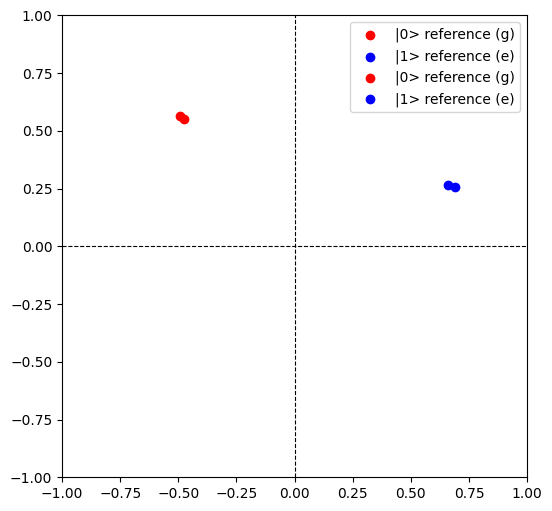

In [310]:
import matplotlib.pyplot as plt

control_g_g_point = rip_data_control_g.data['q0']['cal_trace'].g.data
control_g_e_point = rip_data_control_g.data['q0']['cal_trace'].e.data

control_e_g_point = rip_data_control_e.data['q0']['cal_trace'].g.data
control_e_e_point = rip_data_control_e.data['q0']['cal_trace'].e.data


plt.figure(figsize=(6,6))

plt.scatter(control_g_g_point.real, control_g_g_point.imag, color="red", label="|0> reference (g)")
plt.scatter(control_g_e_point.real, control_g_e_point.imag, color="blue", label="|1> reference (e)")
plt.scatter(control_e_g_point.real, control_e_g_point.imag, color="red", label="|0> reference (g)")
plt.scatter(control_e_e_point.real, control_e_e_point.imag, color="blue", label="|1> reference (e)")

plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.legend()

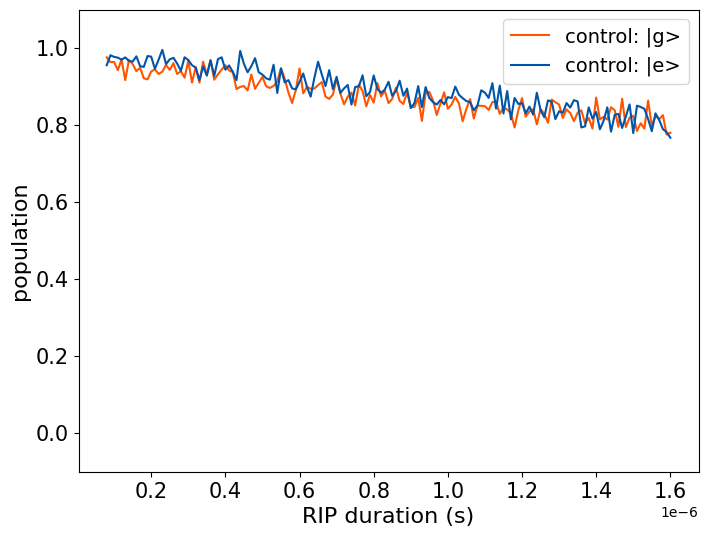

In [311]:
def normalize_population(points, g, e):
    """
    points: list or numpy array of complex numbers
    return: array of normalized values in [0,1]
    """
    points = np.array(points, dtype=complex)
    d0 = np.abs(points - g)
    d1 = np.abs(points - e)
    return d0 / (d0 + d1)

new_phase_control_g = []
new_phase_control_e = []

for i in range(len(phase_control_g)):
    # 2. Calculate the value and append it to the new row
    normalized_value = normalize_population(phase_control_g[i], control_g_g_point, control_g_e_point)
    new_phase_control_g.append(normalized_value)
for k in range(len(phase_control_e)):
    # 2. Calculate the value and append it to the new row
    normalized_value = normalize_population(phase_control_e[k], control_e_g_point, control_e_e_point)
    new_phase_control_e.append(normalized_value)
# 3. Append the completed row to the main population list

population_control_g = new_phase_control_g
population_control_e = new_phase_control_e
plt.figure(figsize=(8,6))
plt.plot(duration, population_control_g, color="#ff5500", label = r'control: |g>')
plt.plot(duration, population_control_e, color="#0055aa", label = r'control: |e>')
plt.ylim([-0.1,1.1])
plt.xlabel("RIP duration (s)", fontsize=16)
plt.ylabel("population", fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(fontsize=14)


# SAVING data 

In [ ]:
#ctrl_g[0].output

Results(
│   errors=[],
│   data=AttributeWrapper(
│   │   q0=AttributeWrapper(
│   │   │   result=AcquiredResult(
│   │   │   │   handle='q0/result',
│   │   │   │   axis_name=[
│   │   │   │   │   [
│   │   │   │   │   │   'wait_time_q0',
│   │   │   │   │   │   'x90_phases_q0'
│   │   │   │   │   ]
│   │   │   │   ],
│   │   │   │   axis=[
│   │   │   │   │   [
│   │   │   │   │   │   array([8.00e-08, 8.40e-08, 8.80e-08, 9.20e-08, 9.60e-08, 1.00e-07,
│      1.04e-07, 1.08e-07, 1.12e-07, 1.16e-07, 1.20e-07, 1.24e-07,
│      1.28e-07, 1.32e-07, 1.36e-07, 1.40e-07, 1.44e-07, 1.48e-07,
│      1.52e-07, 1.56e-07, 1.60e-07, 1.64e-07, 1.68e-07, 1.72e-07,
│      1.76e-07, 1.80e-07, 1.84e-07, 1.88e-07, 1.92e-07, 1.96e-07,
│      2.00e-07, 2.04e-07, 2.08e-07, 2.12e-07, 2.16e-07, 2.20e-07,
│      2.24e-07, 2.28e-07, 2.32e-07, 2.36e-07, 2.40e-07, 2.44e-07,
│      2.48e-07, 2.52e-07, 2.56e-07, 2.60e-07, 2.64e-07, 2.68e-07,
│      2.72e-07, 2.76e-07, 2.80e-07, 2.84e-07, 2.88e-07, 2.92e-07,
│     

In [312]:
from laboneq.simple import save, load

bus_freq_sweep * 1e-9


for i, bf in enumerate(bus_freq_sweep *1e-9):
    save(ctrl_g[i].output, filename=f'1029_rip_control_g_bf_{bf:.3f}_amp1.0')
    save(ctrl_e[i].output, filename=f'1029_rip_control_e_bf_{bf:.3f}_amp1.0')


#save(rip_result_control_g.output, filename='1023_control_g_bf_5.535_amp1.0')
#save(rip_result_control_e.output, filename='1023_control_e_bf_5.535_amp1.0')


In [ ]:
qubits[2].parameters.resonance_targ_frequency = 5.6e9
qubits[2].parameters.resonance_targ_frequency

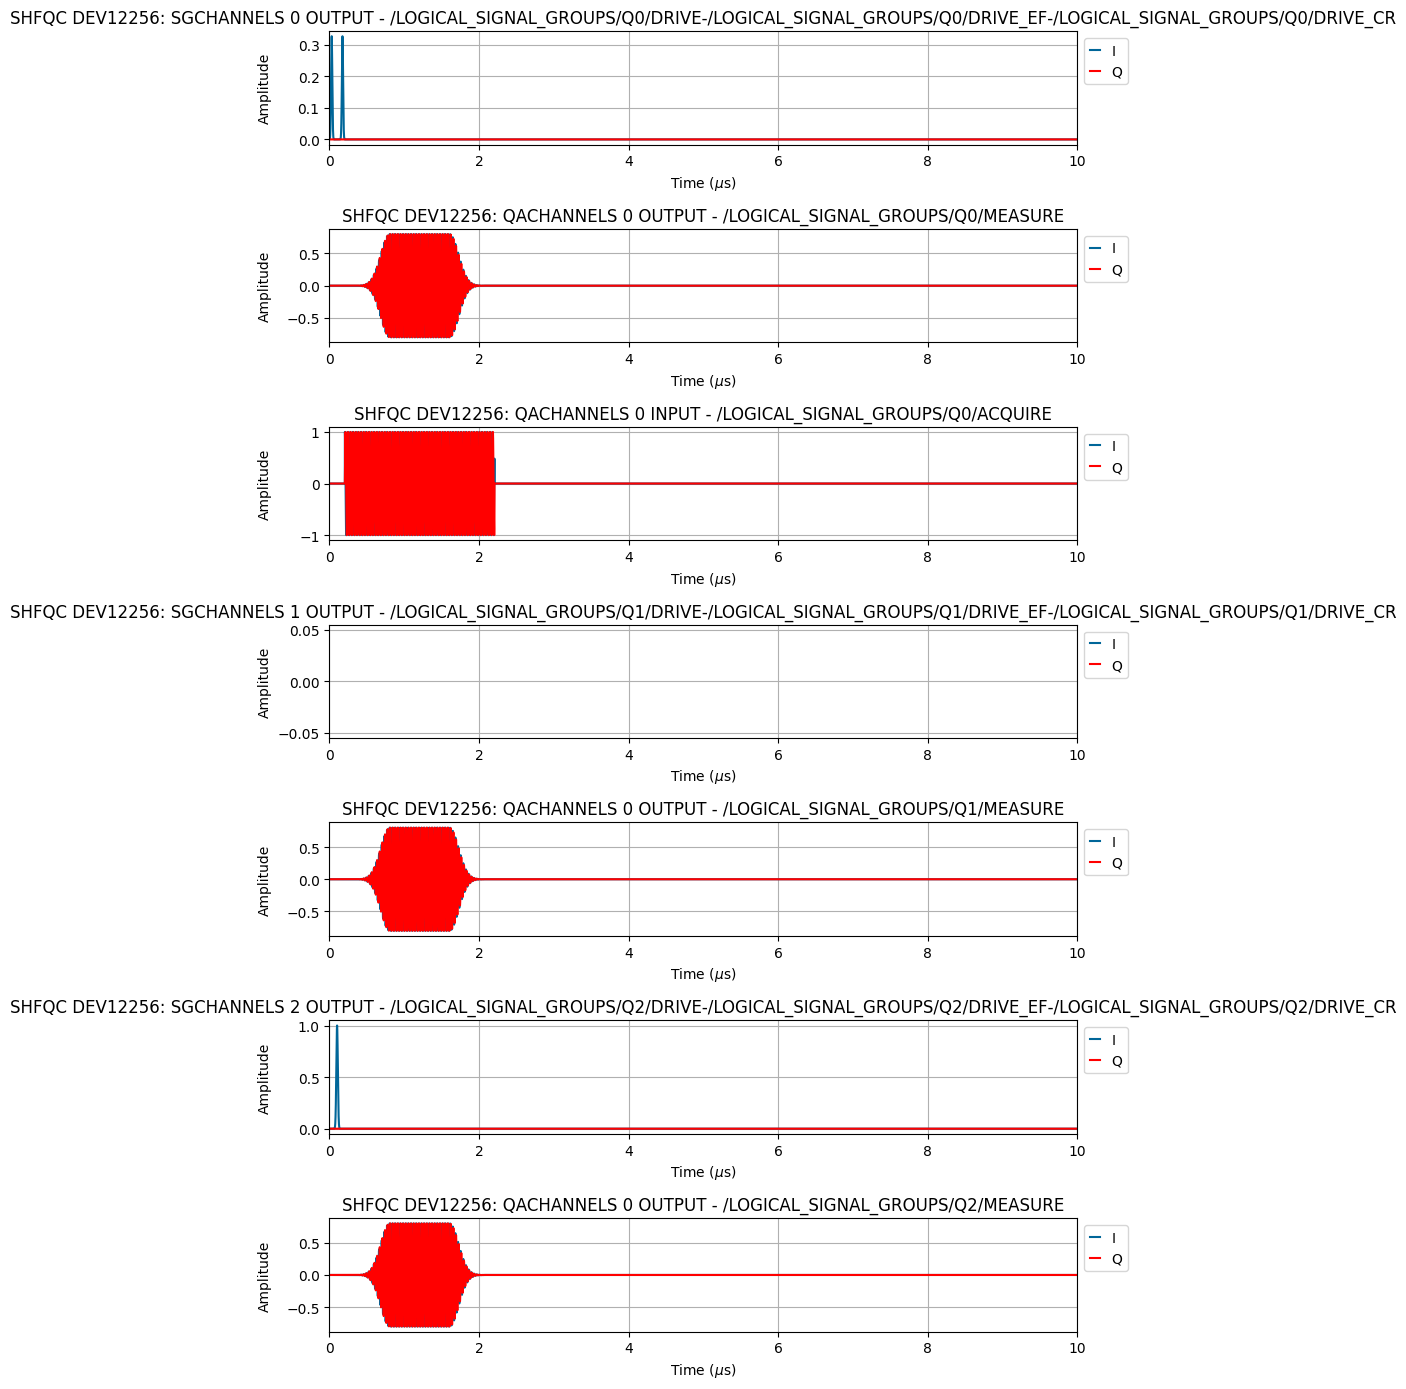

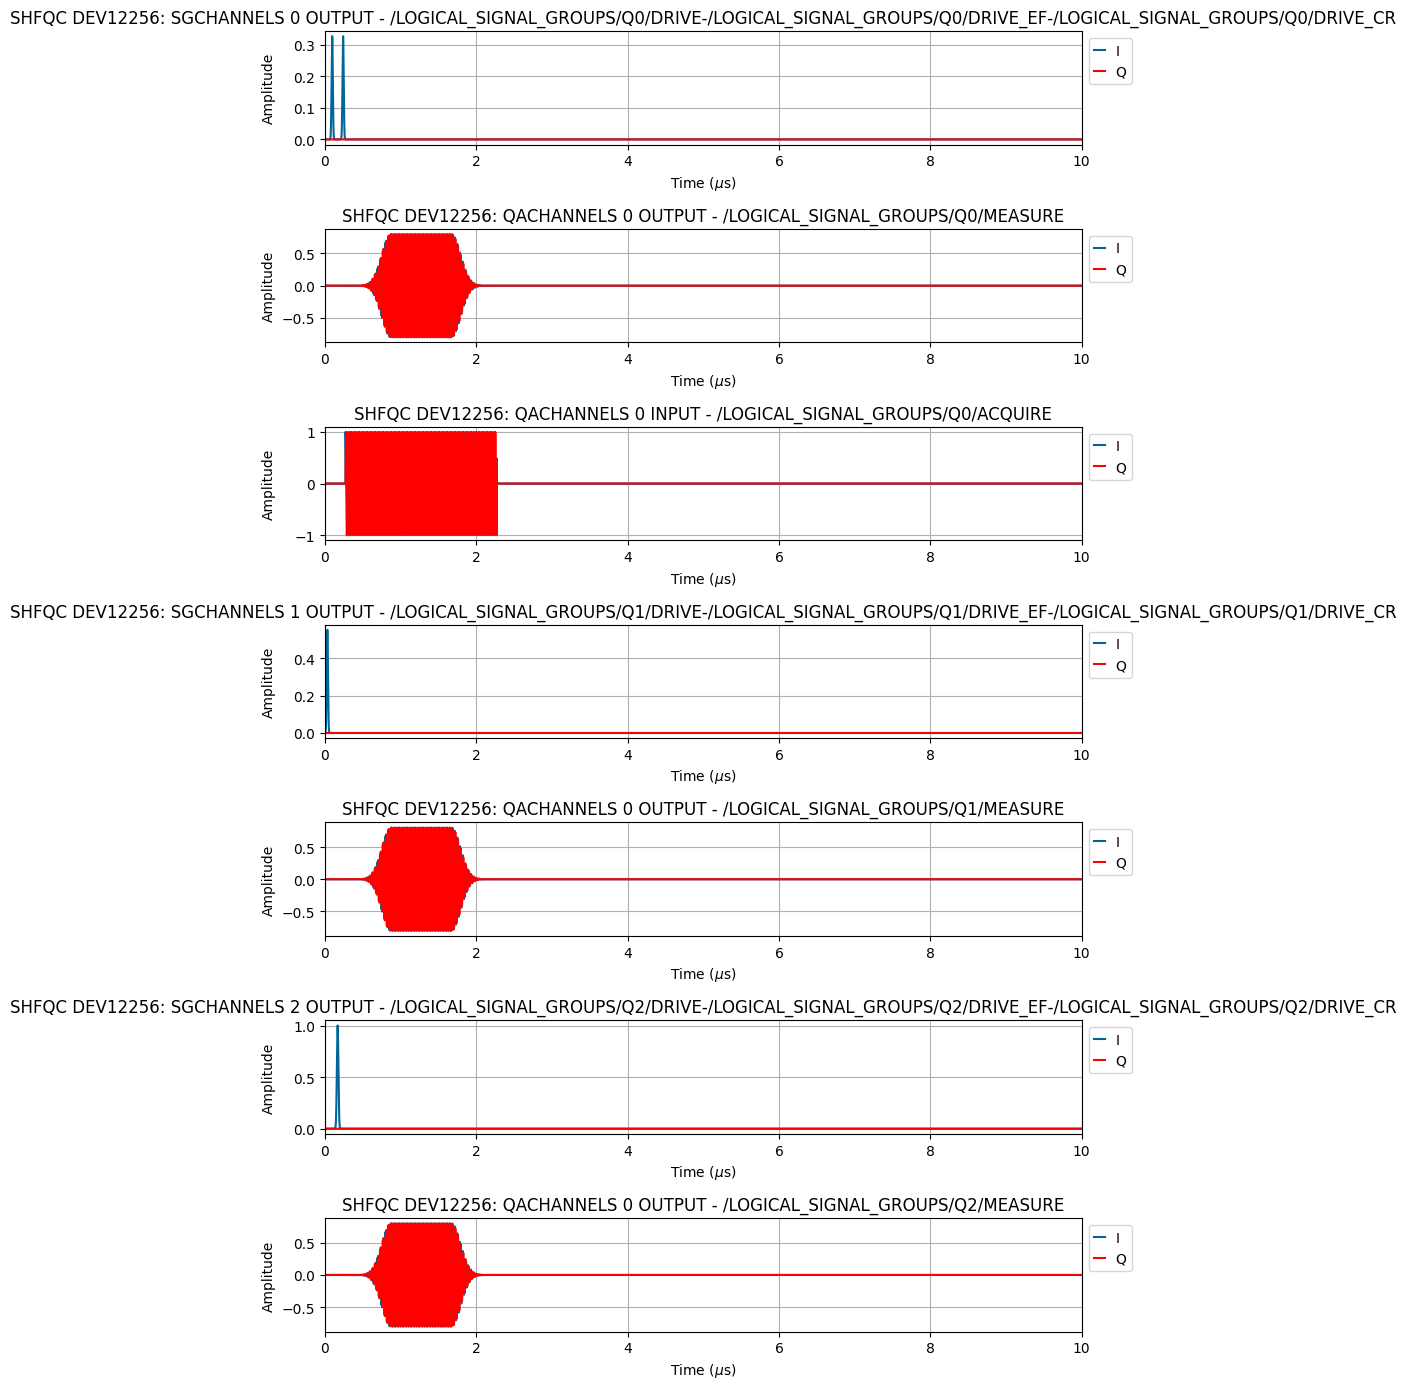

In [ ]:
from laboneq.simple import show_pulse_sheet
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

#show_pulse_sheet(compiled_experiment=rip_result.tasks["compile_experiment"].output,name='test', interactive=True, max_events_to_publish=100000)
plot_simulation(compiled_experiment=rip_result_control_g.tasks["compile_experiment"].output)
plot_simulation(compiled_experiment=rip_result_control_e.tasks["compile_experiment"].output)

In [ ]:
from laboneq.simple import save, load

save(rip_result.output, filename='0909n_e_0.6')
load(filename='0909n_e_0.6')

In [ ]:
from laboneq_applications.analysis.calibration_traces_rotation import (
    calculate_qubit_population_2d,
    calculate_qubit_population
)
targ= qubits[0]
delays=np.linspace(300e-9, 2000e-9,101)
frequencies = qubits[2].parameters.resonance_targ_frequency + np.linspace(-10e6,10e6,6)
processed_d=calculate_qubit_population_2d(qubits=targ, result=rip_result.output, sweep_points_1d=delays, sweep_points_2d=frequencies)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(processed_d['q0']['population'][1,:])
plt.ylim([-0.1, 1.1])
plt.show()

In [ ]:
from laboneq_applications.analysis import iq_blobs
from laboneq_applications.experiments import iq_blobs

#######################################################################
q = qubits[0]

print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
#######################################################################
options = iq_blobs.experiment_workflow.options()

#print(workflow.show_fields(options))

###################################################################
iq = iq_blobs.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    options=options,
    states='ge'
)

iq_result = iq.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(iq_result.tasks['analysis_workflow'].output)


# Basic Readout optimization
Here we optimize SNR via

* `readout_length`
* `readout-amplitude`

* `readout_integration_length`
* `readout_integration_delay`
* `readout_integration_weight`

In [ ]:
from experiments import dispersive_shift

In [ ]:
from experiments import time_traces

# Save Qubit Parameters

In [70]:
from helper import load_qubit_parameters, save_qubit_parameters
save_qubit_parameters(qubits={ qubit.uid : qubit for qubit in qubits}, save_folder="./qubit_parameters/", filename="TG_1029")

Qubit parameters stored as JSON in /home/yalgaeahn/JSAHN/qubit-experiment/examples/qubit_parameters/20251029-1046_TG_1029.json
